<a id="sanity"></a>
# Demo: sanity check in one dimension

In [1]:
## External modules.
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.special import erf

## Internal modules.
from mml.algos.gd import GD_ERM
from mml.losses import Loss
from mml.models import Model
from mml.utils import makedir_safe
from setup_losses import M_Risk
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend

In [2]:
## Create directory to save figures.
#makedir_safe(img_dir) # uncomment if you plan to save figures.

In [3]:
## Setup.
n_train = 10000
num_trials = 100
batch_size = 8
location_wide = 0.0
location_narrow = location_wide + 2.0 # best yet: +2.0
scale_wide = 1.0 # best yet: +1.0
scale_narrow = 0.1
rg = np.random.default_rng()

## Data generation.
def gen_loss_wide(n):
    return np.absolute(rg.normal(loc=location_wide, scale=scale_wide, size=(n,1)))

def gen_loss_narrow(n):
    return np.absolute(rg.normal(loc=location_narrow, scale=scale_narrow, size=(n,1)))

def gen_X(n):
    x1 = gen_loss_wide(n=n)
    x2 = gen_loss_narrow(n=n)
    return np.hstack([x1,x2])


## Custom model class.
class Fixed(Model):
    
    def __init__(self, paras_init, name="Fixed 1-dim model."):
        super().__init__(paras_init=paras_init, name=name)
        return None
    
    
    def func(self, paras=None, X=None):
        n = len(X)
        return self.paras["w"]*np.ones(shape=(n,1))
    
    
    def grad(self, paras=None, X=None):
        model_grads = {}
        model_grads["w"] = np.ones(shape=(n,1,1))
        return model_grads


## Custom loss class.
class Loss_Mixture(Loss):
    
    def __init__(self, name=None):
        super().__init__(name=name)
        return None
    
    
    def func(self, model, X, y=None):
        w = model(X=X)
        return (w*X[:,0:1] + (1.0-w)*X[:,1:2])
    
    
    def grad(self, model, X, y=None):
        loss_grads = {"w": np.expand_dims(a=X[:,0]-X[:,1], axis=(1,2))}
        return loss_grads


In [4]:
# Driver script, given a pre-fixed sigma, and a range of eta values.

## Sigma value.
sigma = np.inf

## Eta value.
todo_eta = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]

## Algorithm setup size.
step_size = 0.001

## Storage over exp settings.
store_over_settings = {}

for eta in todo_eta:
    
    ## Storage over trials.
    store_over_trials = []
    
    print("Working: eta value {}.".format(eta))

    for trial in range(num_trials):

        ## Initial values.
        w_init = 0.5
        theta_init = 0.5
        paras_init = {"w": np.array([w_init], ndmin=2),
                      "theta": np.array([theta_init], ndmin=2)}

        ## Loss setup.
        loss_base = Loss_Mixture()
        loss_mrisk = M_Risk(loss_base=loss_base, sigma=sigma, eta=eta)

        ## Model setup.
        model = Fixed(paras_init=paras_init)

        ## Algorithm setup.
        algo = GD_ERM(step_coef=step_size, model=model, loss=loss_mrisk)

        ## Data setup.
        X_train = gen_X(n=n_train)

        ## Storage of parameter values.
        store_w = [w_init]

        ## Do the training, one datapoint at a time.
        num_steps = n_train // batch_size
        idx_start = 0
        idx_stop = min(batch_size, n_train)
        for step in range(num_steps):
            algo.update(X=X_train[idx_start:idx_stop,:], y=None)
            idx_start += batch_size
            idx_stop = min(idx_start+batch_size, n_train)
            store_w += [algo.paras["w"].item()]

        ## Turn the stored parameters into an ndarray.
        store_w = np.array(store_w)

        ## Store the results for this trial.
        store_over_trials += [store_w]

    ## Prepare the final array of results for this setting.
    store_over_trials = np.array(store_over_trials)
    #print("Shape of results:", store_over_trials.shape)
    
    ## Finally, store this setting-specific array.
    key = str(eta)
    store_over_settings[key] = store_over_trials

Working: eta value 1.0.
Working: eta value 2.0.
Working: eta value 4.0.
Working: eta value 8.0.
Working: eta value 16.0.
Working: eta value 32.0.
Working: eta value 64.0.
Working: eta value 128.0.


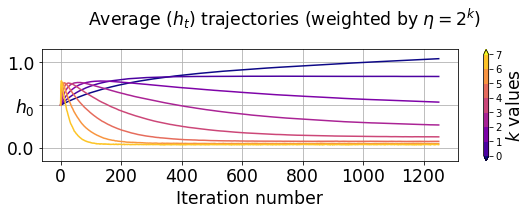

In [5]:
## Colour setup.
eta_cmap = cm.get_cmap("plasma")
eta_names = [key for key in store_over_settings]
eta_colours = {}
for i, key in enumerate(eta_names):
    eta_colours[key] = eta_cmap(i/len(eta_names))

## Visualize the stored parameter values over time.
fig, ax = plt.subplots(1, 1, figsize=(8,3)) # bigger size for detailed viewing.
x_values = np.arange(0, num_steps+1, 1)
for key in store_over_settings:
    y_values = np.mean(store_over_settings[key], axis=0)
    ax.plot(x_values, y_values, color=eta_colours[key], label=key)
ax.set_ylim((0.0-0.15,1.0+0.15))
ticks = [0.0, 0.5, 1.0]
tick_labels = [r"0.0", r"$h_{0}$", r"1.0"]
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels)
ax.tick_params(labelsize=my_fontsize)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set_xlabel("Iteration number", size=my_fontsize)
#ax.legend(loc=None, fontsize=my_fontsize)

cmap = eta_cmap
bounds = [a for a in range(len(eta_names))]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend="both")
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label(label=r"$k$ values", size=my_fontsize)
#cb.ax.tick_params(labelsize=my_fontsize)
fig.suptitle(r"Average $(h_t)$ trajectories (weighted by $\eta = 2^{k}$)", size=my_fontsize)
#ax.set_title("Parameter passed through cross-entropy loss",size=my_fontsize)
fname = os.path.join(img_dir, "trajectory_narrow_wide.{}".format(my_ext))
plt.tight_layout()
#plt.savefig(fname=fname) # uncomment to save figure.
plt.show()


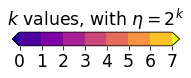

In [6]:
## If desired, we can save a separate colorbar.

fig, ax = plt.subplots(figsize=(3, 0.5))
fig.subplots_adjust(bottom=0.5)
cmap = eta_cmap
bounds = [a for a in range(len(eta_names))]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend="both")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="")
ax.tick_params(labelsize=my_fontsize)
ax.set_title(r"$k$ values, with $\eta = 2^{k}$", size=my_fontsize)
fname = os.path.join(img_dir, "colorbar_narrow_wide.{}".format(my_ext))
#plt.savefig(fname=fname, bbox_inches="tight") # use bbox_inches so text isn't cropped; uncomment to save.
plt.show()

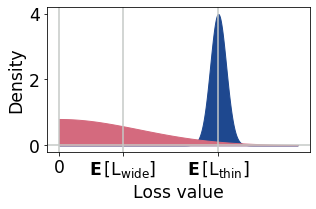

In [7]:
## Plot of our loss-defining example distributions.

def pdf_folded_normal(x, loc=0.0, scale=1.0):
    return (np.exp(-((x-loc)/scale)**2/2) + np.exp(-((x+loc)/scale)**2/2))/(scale*np.sqrt(2*np.pi))

def mean_folded_normal(loc, scale):
    return scale*np.sqrt(2/np.pi)*np.exp(-(loc/scale)**2/2) + loc*erf(loc/np.sqrt(2*scale**2))

fig, ax = plt.subplots(1, 1, figsize=(4.5,3)) # bigger size for detailed viewing.
x_values = np.linspace(0, 3, 1000)
y_narrow = pdf_folded_normal(x=x_values, loc=location_narrow, scale=scale_narrow)
y_wide = pdf_folded_normal(x=x_values, loc=location_wide, scale=scale_wide)
mean_narrow = mean_folded_normal(loc=location_narrow, scale=scale_narrow)
mean_wide = mean_folded_normal(loc=location_wide, scale=scale_wide)
ax.axhline(y=0.0, color="xkcd:silver")
ax.axvline(x=0.0, color="xkcd:silver")
ax.axvline(x=mean_narrow, color="xkcd:silver")
ax.axvline(x=mean_wide, color="xkcd:silver")
ax.fill_between(x_values, y_narrow, 0, color="xkcd:cobalt")
ax.fill_between(x_values, y_wide, 0, color="xkcd:pinkish")
ticks = [0, mean_wide, mean_narrow]
tick_labels = ["0", r"$\mathbf{E}\,[\mathrm{L_{wide}}]$", r"$\mathbf{E}\,[\mathrm{L_{thin}}]$"]
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
#ax.set_yticks([])
ax.set_ylabel("Density", size=my_fontsize)
ax.set_xlabel("Loss value", size=my_fontsize)
ax.tick_params(labelsize=my_fontsize)
plt.tight_layout()
fname = os.path.join(img_dir, "distros_narrow_wide.{}".format(my_ext))
#plt.savefig(fname=fname) # uncomment to save figure.
plt.show()


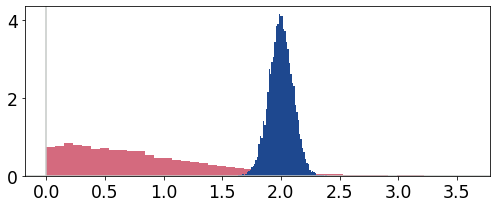

In [9]:
## Histograms of our loss-defining example distributions.

sample_narrow = gen_loss_narrow(n=10000)
sample_wide = gen_loss_wide(n=10000)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,3))
ax.axhline(y=0.0, color="xkcd:silver")
ax.axvline(x=0.0, color="xkcd:silver")
ax.hist(sample_wide, color="xkcd:pinkish", bins="auto", hatch=None, density=True)
ax.hist(sample_narrow, color="xkcd:cobalt", bins="auto", hatch=None, density=True)
ax.tick_params(labelsize=my_fontsize)
plt.tight_layout()
plt.show()

___